## Setup

In [1]:
!pip install protobuf==3.20.3
!pip install lz4
!pip uninstall mediapipe -y
!pip install mediapipe
!pip install retina-face
!pip install MTCNN
!pip install ultralytics opencv-python numpy
!pip install dlib
!pip install supervision
!pip install opencv-python-headless
!pip install grad-cam

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.7 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 41.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 12.0 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-core 1.34.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<4.0.0dev,>=3.19.5, but you have protobuf 4.25.6 which is incompatible.
google-cloud-bigtable 2.27.0 requires google-api-core[grpc]<3.0.0dev,>=2.16.0, but you have google-api-core 1.34.1 which is incompatible.
pandas-gbq 0.25.0 requires google-api-core<3.0.0dev,>=2.10.2, but you have google-api-c

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2 
import torch
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Input, TimeDistributed, GlobalAveragePooling2D, LSTM, Dense 
from tensorflow.keras.applications import ResNet50 
import time 
import mediapipe as mp
import datetime
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from retinaface import RetinaFace
import tensorflow as tf
from huggingface_hub import hf_hub_download
from ultralytics import YOLO
from supervision import Detections
from mtcnn import MTCNN
import dlib
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, roc_auc_score
import tempfile
import tensorflow.keras.backend as K
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from tensorflow.keras.layers import Bidirectional, Attention, Concatenate


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
/kaggle/input/mmod_human_face_detector/other/default/1/mmod_human_face_detector.dat
/kaggle/input/celebe-real/id1_0006.mp4
/kaggle/input/celebe-real/id0_0005.mp4
/kaggle/input/celebe-real/id0_0008.mp4
/kaggle/input/celebe-real/id3_0008.mp4
/kaggle/input/celebe-real/id2_0007.mp4
/kaggle/input/celebe-real/id2_0000.mp4
/kaggle/input/celebe-real/id3_0004.mp4
/kaggle/input/celebe-real/id4_0002.mp4
/kaggle/input/celebe-real/id0_0009.mp4
/kaggle/input/celebe-real/id2_0006.mp4
/kaggle/input/celebe-real/id1_0008.mp4
/kaggle/input/celebe-real/id2_0002.mp4
/kaggle/input/celebe-real/id4_0003.mp4
/kaggle/input/celebe-real/id1_0001.mp4
/kaggle/input/celebe-real/id0_0002.mp4
/kaggle/input/celebe

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Model

In [4]:
input_shape = (16, 224, 224, 3)

In [8]:
inputs = Input(shape=input_shape) 
base_model = ResNet50(
    weights='imagenet', 
    include_top=False, 
    input_shape=(224, 224, 3)) 
x = TimeDistributed(base_model)(inputs) 
x = TimeDistributed(GlobalAveragePooling2D())(x) 
x = LSTM(128)(x) 
x = Dense(128, activation='relu')(x) 
outputs = Dense(1, activation='sigmoid')(x)

In [9]:
loaded_model = Model(inputs, outputs) 
loaded_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
loaded_model.load_weights('/kaggle/input/liveness_classifier/tensorflow2/default/1/resnet_model.h5')

In [ ]:
loaded_model.summary()

## Preprocessing  

In [12]:
def extract_frames(video_path, process, interval=5, num_frames=16, target_size=(224, 224)):
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % interval == 0:
            detected_frame = detect_face(frame, process)
            if detected_frame is not None:
                frames.append(detected_frame)
        
        if len(frames) == num_frames:
            break
        frame_count += 1

    cap.release()

    # Preencher se não tivermos 16 frames
    while len(frames) < num_frames:
        frames.append(frames[-1] if frames else np.zeros((*target_size, 3), dtype=np.uint8))

    return np.array(frames) if frames else None

### Extract faces

In [13]:
def detect_face(frame, process):
    if process == 'haar':
        return extract_face_haar(frame)
    if process == 'mtcnn':
        return extract_face_mtcnn(frame)
    if process == 'yolo':
        return extract_faces_yolo(frame)
    if process == 'ssd':
        return extract_faces_ssd(frame)
    if process == 'dlib':
        return extract_face_dlib(frame)
    if process == 'mediapipe':
        return extract_face_mediapipe(frame)
    
    print(f"Erro: Processo '{process}' não reconhecido")
    return None

In [45]:
def extract_face_dlib(frame, target_size=(224, 224)):
    dlib.DLIB_USE_CUDA = False 
    detector = dlib.get_frontal_face_detector()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)

    if len(faces) > 0:  # Correção aqui
        face = faces[0]  # Removido `.rect`
        x1, y1, x2, y2 = face.left(), face.top(), face.right(), face.bottom()
        
        h, w = frame.shape[:2]
        x1, y1, x2, y2 = max(0, x1), max(0, y1), min(w, x2), min(h, y2)

        face_img = frame[y1:y2, x1:x2]
        return cv2.resize(face_img, target_size)

    print("Nenhuma face encontrada. Retornando frame original redimensionado. - DLIB")
    return cv2.resize(frame, target_size)

In [46]:
def extract_face_haar(frame, target_size=(224, 224)):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5, minSize=(30, 30))

    if len(faces) > 0:  # Correção aqui
        x, y, w, h = faces[0]
        face = frame[y:y+h, x:x+w]
        return cv2.resize(face, target_size)

    print("Nenhuma face encontrada. Retornando frame original redimensionado. - HAAR")
    return cv2.resize(frame, target_size)

In [47]:
# Inicializar o detector de face MTCNN
detector = MTCNN()

def extract_face_mtcnn(frame, target_size=(224, 224)):  
    print('mtcnn')
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Converter para RGB
    faces = detector.detect_faces(frame_rgb)
    
    if faces:
        x, y, w, h = faces[0]['box']  # Pega a primeira face detectada
        x, y = max(0, x), max(0, y)
        face = frame[y:y+h, x:x+w]
        face_resized = cv2.resize(face, target_size)  # Redimensionar
        return face_resized
    
    print("Nenhuma face encontrada. Retornando frame original redimensionado. - MTCNN")
    return cv2.resize(frame, target_size)

In [48]:
mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils
def extract_face_mediapipe(frame, target_size=(224, 224)):    
    with mp_face_detection.FaceDetection(min_detection_confidence=0.5) as face_detection:
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = face_detection.process(frame_rgb)  # Correção aqui

        if results and results.detections:  # Verificação corrigida
            detection = results.detections[0]
            bboxC = detection.location_data.relative_bounding_box
            h, w, _ = frame.shape
            x1, y1 = int(bboxC.xmin * w), int(bboxC.ymin * h)
            x2, y2 = int((bboxC.xmin + bboxC.width) * w), int((bboxC.ymin + bboxC.height) * h)
            
            x1, y1, x2, y2 = max(0, x1), max(0, y1), min(w, x2), min(h, y2)
            face = frame[y1:y2, x1:x2]
            face_resized = cv2.resize(face, target_size)
            return face_resized
    
    print("Nenhuma face encontrada. Retornando frame original redimensionado. - Media Pipe")
    return cv2.resize(frame, target_size)



In [49]:
def extract_faces_ssd(frame, target_size=(224, 224)):
    model_path = "/kaggle/input/caffe-face-detector-opencv-pretrained-model/"
    prototxt = model_path + "architecture.txt"
    weights = model_path + "weights.caffemodel"
    
    net = cv2.dnn.readNetFromCaffe(prototxt, weights)

    (h, w) = frame.shape[:2]
    
    blob = cv2.dnn.blobFromImage(frame, scalefactor=1.0, size=(300, 300),
                                 mean=(104.0, 177.0, 123.0), swapRB=False, crop=False)
    
    net.setInput(blob)
    detections = net.forward()

    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        
        if confidence > 0.5:  
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (x1, y1, x2, y2) = box.astype("int")

            x1, y1, x2, y2 = max(0, x1), max(0, y1), min(w - 1, x2), min(h - 1, y2)

            if x2 > x1 and y2 > y1:
                face = frame[y1:y2, x1:x2]  # Recortar a face
                return cv2.resize(face, target_size)

    print("Nenhuma face encontrada. Retornando frame original redimensionado. - SSD")
    return cv2.resize(frame, target_size)

In [14]:
def extract_faces_yolo(frame, target_size=(224, 224)):
    model_path = hf_hub_download(repo_id="arnabdhar/YOLOv8-Face-Detection", filename="model.pt")
    
    model = YOLO(model_path)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Converter para RGB
    results = model(frame_rgb)[0]
    if len(results.boxes) > 0:
        x1, y1, x2, y2 = map(int, results.boxes.xyxy[0])

        h, w, _ = frame.shape
        x1, y1, x2, y2 = max(0, x1), max(0, y1), min(w, x2), min(h, y2)

        face = frame[y1:y2, x1:x2]
        return cv2.resize(face, target_size)

    print("Nenhuma face encontrada. Retornando frame original redimensionado. - DLIB")
    return cv2.resize(frame, target_size)

### Embedding 

### XAI

In [85]:
def extract_frames_from_video(video_path, extract_face_process, num_frames=16):
    cap = cv2.VideoCapture(video_path)
    frames = []
    
    # Verificando se o vídeo foi aberto corretamente
    if not cap.isOpened():
        print("Erro ao abrir o vídeo!")
        return None
    
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    step = max(frame_count // num_frames, 1)
    
    for i in range(num_frames):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i * step)
        ret, frame = cap.read()
        detected_frame = detect_face(frame, extract_face_process)
        if not ret:
            break
        frames.append(detected_frame)
    
    cap.release()
    return frames

def apply_fourier_transform(frame):
    if len(frame.shape) == 3 and frame.shape[2] == 3:
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    else:
        gray_frame = frame 

    f = np.fft.fft2(gray_frame)  
    fshift = np.fft.fftshift(f)  
    magnitude = np.abs(fshift)
    
    return magnitude

def save_frequency_analysis(frames,video_path, extract_face_method, num_frames=16):
    folder_path = os.path.join(extract_face_method, video_path.replace('/', '_'))
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    for i, frame in enumerate(frames):
        magnitude = apply_fourier_transform(frame)
        
        save_path = os.path.join(folder_path, f"frame_{i+1}.png")
        plt.figure(figsize=(6, 6))
        plt.imshow(np.log(magnitude + 1), cmap='hot')  # Aplicando logaritmo para melhor visualização
        plt.axis('off')
        plt.savefig(save_path, bbox_inches='tight')
        plt.close()

## Predict class

In [86]:
def predict_video_class(video_path, model, extract_face):
    frames = extract_frames(video_path, extract_face)  

    if frames is None or len(frames) == 0:
        print(f"Erro: Nenhum frame extraído de {video_path}")
        return None, None

    frames = np.array(frames) / 255.0  # Normalizar os frames

    frames = np.expand_dims(frames, axis=0)  # Adiciona batch dimension
    
    prediction = model.predict(frames)

    prob_deepfake = prediction[0][0] 

    threshold = 0.5
    pred_label = "Real" if prob_deepfake >= threshold else "Deepfake"

    return pred_label, prob_deepfake


In [53]:
def predict_and_generate_frequency_analysis(video_path, model, extract_face_method='yolo', num_frames=16):
    frames = extract_frames_from_video(video_path, num_frames=num_frames, extract_face_process = extract_face_method)  # Extraindo frames do vídeo
    
    if frames is None or len(frames) == 0:
        print(f"Erro: Nenhum frame extraído de {video_path}")
        return None, None
    
    frames_normalized = np.array(frames) / 255.0  # Normalizando os frames
    frames_expanded = np.expand_dims(frames_normalized, axis=0)  # Adicionando a dimensão do batch (formato [1, 16, 224, 224, 3])

    # Prevendo com o modelo
    prediction = model.predict(frames_expanded)
    prob_deepfake = prediction[0][0]
    
    # Rótulo predito
    threshold = 0.5
    pred_label = "Real" if prob_deepfake >= threshold else "Deepfake"

    # Visualizar a análise de frequência
    save_frequency_analysis(frames, video_path, extract_face_method)

    return pred_label, prob_deepfake

### Predict Fake

In [87]:
video_path = "/kaggle/input/celeb-fake/id0_id1_0000.mp4"
predict_and_generate_frequency_analysis(video_path, loaded_model,'yolo')


0: 352x640 1 FACE, 99.8ms
Speed: 3.9ms preprocess, 99.8ms inference, 1.1ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 FACE, 94.7ms
Speed: 3.9ms preprocess, 94.7ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 FACE, 93.3ms
Speed: 2.8ms preprocess, 93.3ms inference, 1.1ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 FACE, 95.4ms
Speed: 2.4ms preprocess, 95.4ms inference, 1.1ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 FACE, 95.3ms
Speed: 2.3ms preprocess, 95.3ms inference, 1.1ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 FACE, 93.2ms
Speed: 3.4ms preprocess, 93.2ms inference, 1.1ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 FACE, 101.6ms
Speed: 2.3ms preprocess, 101.6ms inference, 1.1ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 FACE, 98.5ms
Speed: 3.5ms preprocess, 98.5ms inference, 1.1ms postprocess per image at shape (1, 3, 352, 640)

0: 35

('Real', 0.53607494)

### Predict Real


0: 608x640 1 FACE, 160.8ms
Speed: 3.8ms preprocess, 160.8ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)

0: 608x640 1 FACE, 138.5ms
Speed: 3.5ms preprocess, 138.5ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)

0: 608x640 1 FACE, 136.4ms
Speed: 3.6ms preprocess, 136.4ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)

0: 608x640 1 FACE, 138.7ms
Speed: 3.6ms preprocess, 138.7ms inference, 1.5ms postprocess per image at shape (1, 3, 608, 640)

0: 608x640 1 FACE, 135.4ms
Speed: 3.5ms preprocess, 135.4ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)

0: 608x640 1 FACE, 136.5ms
Speed: 3.7ms preprocess, 136.5ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)

0: 608x640 1 FACE, 137.6ms
Speed: 3.5ms preprocess, 137.6ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)

0: 608x640 1 FACE, 137.7ms
Speed: 3.7ms preprocess, 137.7ms inference, 1.0ms postprocess per image at shape (1, 3, 60

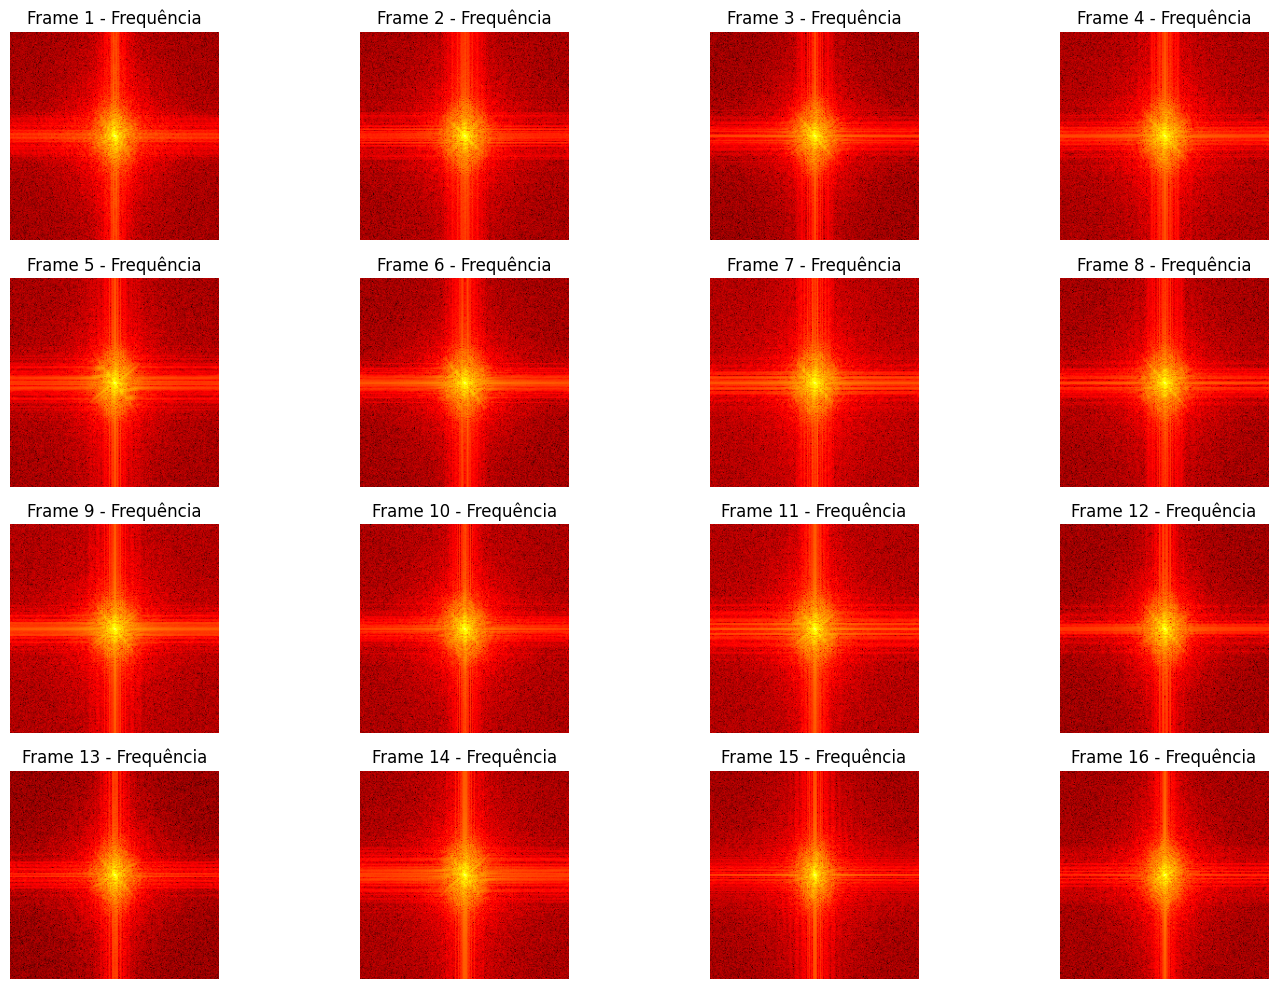

('Real', 0.6136916)

In [36]:
video_path = "/kaggle/input/celebe-real/id3_0001.mp4"
predict_and_generate_frequency_analysis(video_path, loaded_model,'yolo')

## Evaluate videos - Extract faces

In [43]:
def evaluate_videos(video_dir, extract_face):
    print(extract_face)
    initial_time = datetime.datetime.now()
    print(f"Start at {initial_time.strftime('%d-%m-%Y %H:%M:%S')}")
    
    true_labels = []
    pred_labels = []
    pred_probs = []  

    for class_label in  ["Real", "Deepfake"]:
        class_label_dir = "celebe-real" if class_label == "Real" else "celeb-fake"
        class_dir = os.path.join(video_dir, class_label_dir)
        print(class_dir)

        if not os.path.exists(class_dir):
            continue

        video_files = sorted([f for f in os.listdir(class_dir) if f.endswith(".mp4")])

        for video_file in video_files:
            video_path = os.path.join(class_dir, video_file)
            print(f"\nProcessando: {video_file} ({class_label})")

            # Extração de frames e detecção de deepfake

            label, confidence = predict_and_generate_frequency_analysis(video_path, loaded_model, extract_face)

            pred_label = label

            # Salvar rótulos reais e preditos
            true_labels.append(1 if class_label == "Real" else 0)  
            pred_labels.append(1 if pred_label == "Real" else 0)
            pred_probs.append(confidence)

    # Gerar matriz de confusão
    cm = confusion_matrix(true_labels, pred_labels)
    df_cm = pd.DataFrame(cm, index=["Real", "Deepfake"], columns=["Predito Real", "Predito Deepfake"])

    # Exibir matriz de confusão
    plt.figure(figsize=(6, 5))
    sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
    plt.xlabel("Predição")
    plt.ylabel("Real")
    plt.title("Matriz de Confusão - Detecção de Deepfake")
    plt.show()

    # Calcular métricas
    acc = accuracy_score(true_labels, pred_labels)
    f1 = f1_score(true_labels, pred_labels)
    auc = roc_auc_score(true_labels, pred_probs) if len(set(true_labels)) > 1 else None 
    
    # Exibir relatório de classificação
    print("\nRelatório de Classificação:")
    print(classification_report(true_labels, pred_labels, target_names=["Real", "Deepfake"]))
    print(f"Acurácia: {acc:.4f}")
    print(f"F1-score: {f1:.4f}")
    if auc is not None:
        print(f"AUC: {auc:.4f}")
    else:
        print("AUC: Não disponível (apenas uma classe presente nos dados)")

    final_time = datetime.datetime.now()
    duration = final_time - initial_time
    print(f"Finish at {final_time.strftime('%d-%m-%Y %H:%M:%S')}, duration: {duration}")
    
    return acc, f1, auc


ssd
Start at 19-03-2025 16:17:26
/kaggle/input/celebe-real

Processando: id0_0000.mp4 (Real)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Processando: id0_0001.mp4 (Real)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Processando: id0_0002.mp4 (Real)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Processando: id0_0003.mp4 (Real)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Processando: id0_0004.mp4 (Real)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

Processando: id0_0005.mp4 (Real)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Processando: id0_0006.mp4 (Real)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Processando: id0_0007.mp4 (Real)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Processando: id0_0008.mp4 (Real)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Processando: id0_0009.mp4 (Real)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Processando: id1_0000.mp4 (Real)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Processando: id1_0001.mp4 (Real)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Processando: id1_0002.mp4 (Real)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Processando: id1_0003.mp4 (Rea

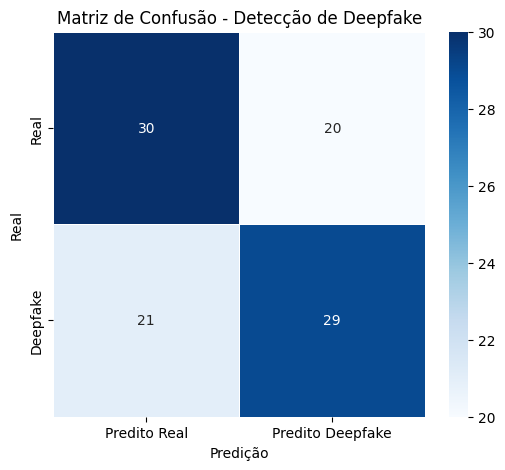


Relatório de Classificação:
              precision    recall  f1-score   support

        Real       0.59      0.60      0.59        50
    Deepfake       0.59      0.58      0.59        50

    accuracy                           0.59       100
   macro avg       0.59      0.59      0.59       100
weighted avg       0.59      0.59      0.59       100

Acurácia: 0.5900
F1-score: 0.5859
AUC: 0.6408
Finish at 19-03-2025 16:30:03, duration: 0:12:36.191589


(0.59, 0.5858585858585857, 0.6408)

In [65]:
## Diretório de vídeos de teste SSD
video_test_dir = "/kaggle/input/"

# Avaliação de todos os vídeos no diretório
evaluate_videos(video_test_dir, 'ssd')

dlib
Start at 19-03-2025 15:55:59
/kaggle/input/celebe-real

Processando: id0_0000.mp4 (Real)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Processando: id0_0001.mp4 (Real)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Processando: id0_0002.mp4 (Real)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Processando: id0_0003.mp4 (Real)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

Processando: id0_0004.mp4 (Real)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Processando: id0_0005.mp4 (Real)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Processando: id0_0006.mp4 (Real)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Processando: id0_0007.mp4 (Real)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Processando: id0_0008.mp4 (Real)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Processando: id0_0009.mp4 (Real)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Processando: id1_0000.mp4 (Real)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Processando: id1_0001.mp4 (Real)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Processando: id1_0002.mp4 (Real)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Processando: id1_0003.mp4 (Re

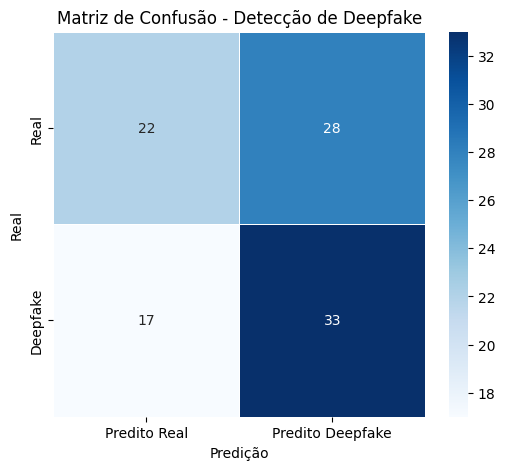


Relatório de Classificação:
              precision    recall  f1-score   support

        Real       0.56      0.44      0.49        50
    Deepfake       0.54      0.66      0.59        50

    accuracy                           0.55       100
   macro avg       0.55      0.55      0.54       100
weighted avg       0.55      0.55      0.54       100

Acurácia: 0.5500
F1-score: 0.5946
AUC: 0.6224
Finish at 19-03-2025 16:17:26, duration: 0:21:27.608449


(0.55, 0.5945945945945946, 0.6224000000000001)

In [64]:
## Diretório de vídeos de teste DLIB
video_test_dir = "/kaggle/input/"

# Avaliação de todos os vídeos no diretório
evaluate_videos(video_test_dir, 'dlib')

yolo
Start at 19-03-2025 15:36:57
/kaggle/input/celebe-real

Processando: id0_0000.mp4 (Real)

0: 352x640 1 FACE, 98.6ms
Speed: 3.0ms preprocess, 98.6ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 FACE, 97.9ms
Speed: 2.9ms preprocess, 97.9ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 FACE, 90.4ms
Speed: 2.5ms preprocess, 90.4ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 FACE, 90.9ms
Speed: 2.6ms preprocess, 90.9ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 FACE, 95.0ms
Speed: 2.5ms preprocess, 95.0ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 FACE, 97.7ms
Speed: 2.6ms preprocess, 97.7ms inference, 1.1ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 FACE, 90.4ms
Speed: 2.6ms preprocess, 90.4ms inference, 1.1ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 FACE, 86.8ms
Speed: 2.9m

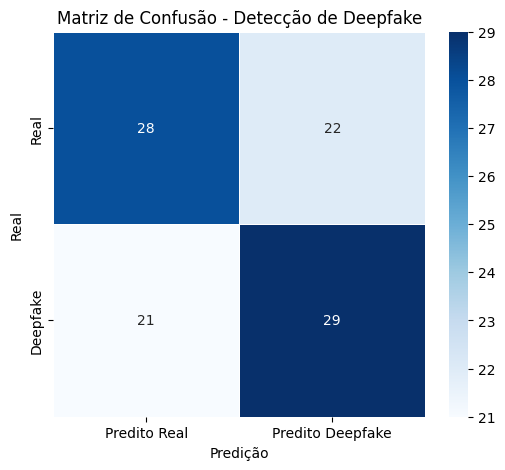


Relatório de Classificação:
              precision    recall  f1-score   support

        Real       0.57      0.56      0.57        50
    Deepfake       0.57      0.58      0.57        50

    accuracy                           0.57       100
   macro avg       0.57      0.57      0.57       100
weighted avg       0.57      0.57      0.57       100

Acurácia: 0.5700
F1-score: 0.5743
AUC: 0.6428
Finish at 19-03-2025 15:55:59, duration: 0:19:01.873197


(0.57, 0.5742574257425743, 0.6427999999999999)

In [63]:
## Diretório de vídeos de teste YOLO
video_test_dir = "/kaggle/input/"

# Avaliação de todos os vídeos no diretório
evaluate_videos(video_test_dir, 'yolo')

mediapipe
Start at 19-03-2025 15:27:31
/kaggle/input/celebe-real

Processando: id0_0000.mp4 (Real)
Nenhuma face encontrada. Retornando frame original redimensionado. - Media Pipe
Nenhuma face encontrada. Retornando frame original redimensionado. - Media Pipe
Nenhuma face encontrada. Retornando frame original redimensionado. - Media Pipe
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

Processando: id0_0001.mp4 (Real)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Processando: id0_0002.mp4 (Real)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Processando: id0_0003.mp4 (Real)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Processando: id0_0004.mp4 (Real)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Processando: id0_0005.mp4 (Real)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Processando: id0_0006.mp4 (Real)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Processando: id0_0007.mp4 (Real)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Processando: id0_0008.mp4 (Real)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Processando: id0_0009.mp4 (Real)
Nenhuma face encontrada. Retorn

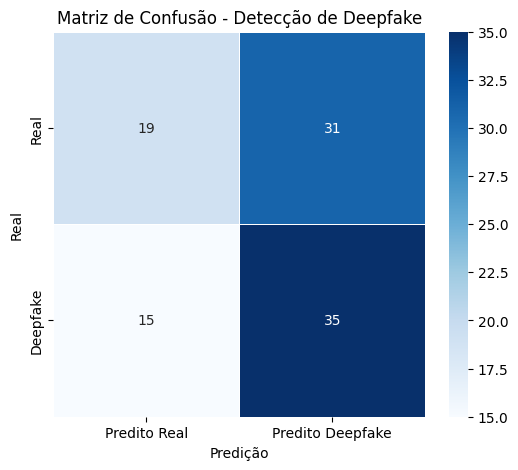


Relatório de Classificação:
              precision    recall  f1-score   support

        Real       0.56      0.38      0.45        50
    Deepfake       0.53      0.70      0.60        50

    accuracy                           0.54       100
   macro avg       0.54      0.54      0.53       100
weighted avg       0.54      0.54      0.53       100

Acurácia: 0.5400
F1-score: 0.6034
AUC: 0.5876
Finish at 19-03-2025 15:36:57, duration: 0:09:26.308267


(0.54, 0.603448275862069, 0.5876)

In [62]:
## Diretório de vídeos de teste 
video_test_dir = "/kaggle/input/"

# Avaliação de todos os vídeos no diretório
evaluate_videos(video_test_dir,'mediapipe')

haar
Start at 19-03-2025 16:30:03
/kaggle/input/celebe-real

Processando: id0_0000.mp4 (Real)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Processando: id0_0001.mp4 (Real)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Processando: id0_0002.mp4 (Real)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Processando: id0_0003.mp4 (Real)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Processando: id0_0004.mp4 (Real)
Nenhuma face encontrada. Retornando frame original redimensionado. - HAAR
Nenhuma face encontrada. Retornando frame original redimensionado. - HAAR
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Processando: id0_0005.mp4 (Real)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Processando: id0_0006.mp4 (Real)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Processando: id0_0007.mp4 (Real)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Processando: id0_0008.mp4 (Real)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Processando: id0_0009.mp4 (Real)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Processando: id1_0000.mp4 (Real)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Processando: id1_0001

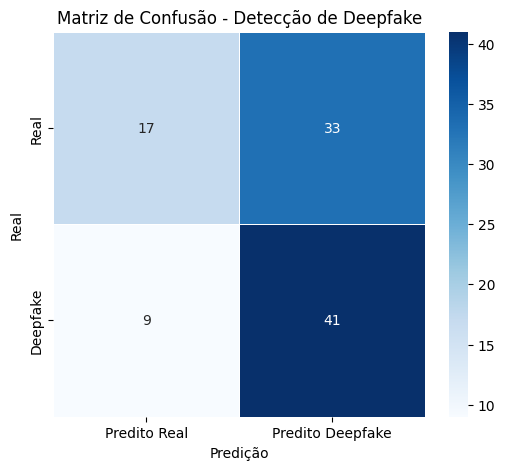


Relatório de Classificação:
              precision    recall  f1-score   support

        Real       0.65      0.34      0.45        50
    Deepfake       0.55      0.82      0.66        50

    accuracy                           0.58       100
   macro avg       0.60      0.58      0.55       100
weighted avg       0.60      0.58      0.55       100

Acurácia: 0.5800
F1-score: 0.6613
AUC: 0.6016
Finish at 19-03-2025 16:42:29, duration: 0:12:26.453863


(0.58, 0.6612903225806451, 0.6016)

In [66]:
## Diretório de vídeos de teste Haar
video_test_dir = "/kaggle/input/"

# Avaliação de todos os vídeos no diretório
evaluate_videos(video_test_dir, 'haar')

mtcnn
Start at 19-03-2025 16:42:29
/kaggle/input/celebe-real

Processando: id0_0000.mp4 (Real)
mtcnn
mtcnn
mtcnn
mtcnn
mtcnn
mtcnn
mtcnn
mtcnn
mtcnn
mtcnn
mtcnn
mtcnn
mtcnn
mtcnn
mtcnn
mtcnn
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Processando: id0_0001.mp4 (Real)
mtcnn
mtcnn
mtcnn
mtcnn
mtcnn
mtcnn
mtcnn
mtcnn
mtcnn
mtcnn
mtcnn
mtcnn
mtcnn
mtcnn
mtcnn
mtcnn
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Processando: id0_0002.mp4 (Real)
mtcnn
mtcnn
mtcnn
mtcnn
mtcnn
mtcnn
mtcnn
mtcnn
mtcnn
mtcnn
mtcnn
mtcnn
mtcnn
mtcnn
mtcnn
mtcnn
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

Processando: id0_0003.mp4 (Real)
mtcnn
mtcnn
mtcnn
mtcnn
mtcnn
mtcnn
mtcnn
mtcnn
mtcnn
mtcnn
mtcnn
mtcnn
mtcnn
mtcnn
mtcnn
mtcnn
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Processando: id0_0004.mp4 (Real)
mtcnn
mtcnn
mtcnn
mtcnn
mtcnn
mtcnn
mtcnn
mtcnn
mtcnn
mtcnn
mtcnn
mtcnn
mtcnn
mtcnn
mtcnn
mtcnn
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Processando: id0_0005.mp4 (Real)
mtcnn
mtcnn
mtcnn
mtcnn
mtcnn
mtcnn
mtcnn
mtcnn
mtcnn
mtcnn
mtcnn
mtcnn
mtc

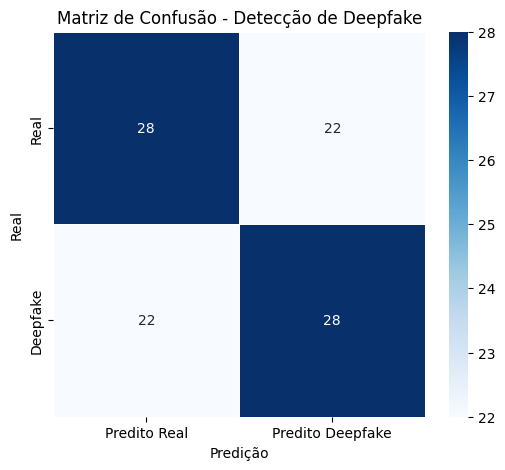


Relatório de Classificação:
              precision    recall  f1-score   support

        Real       0.56      0.56      0.56        50
    Deepfake       0.56      0.56      0.56        50

    accuracy                           0.56       100
   macro avg       0.56      0.56      0.56       100
weighted avg       0.56      0.56      0.56       100

Acurácia: 0.5600
F1-score: 0.5600
AUC: 0.5912
Finish at 19-03-2025 17:01:59, duration: 0:19:29.557699


(0.56, 0.56, 0.5912000000000001)

In [67]:
## Diretório de vídeos de teste MTCNN
video_test_dir = "/kaggle/input/"

# Avaliação de todos os vídeos no diretório
evaluate_videos(video_test_dir, 'mtcnn')

### Rascunho frequência

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


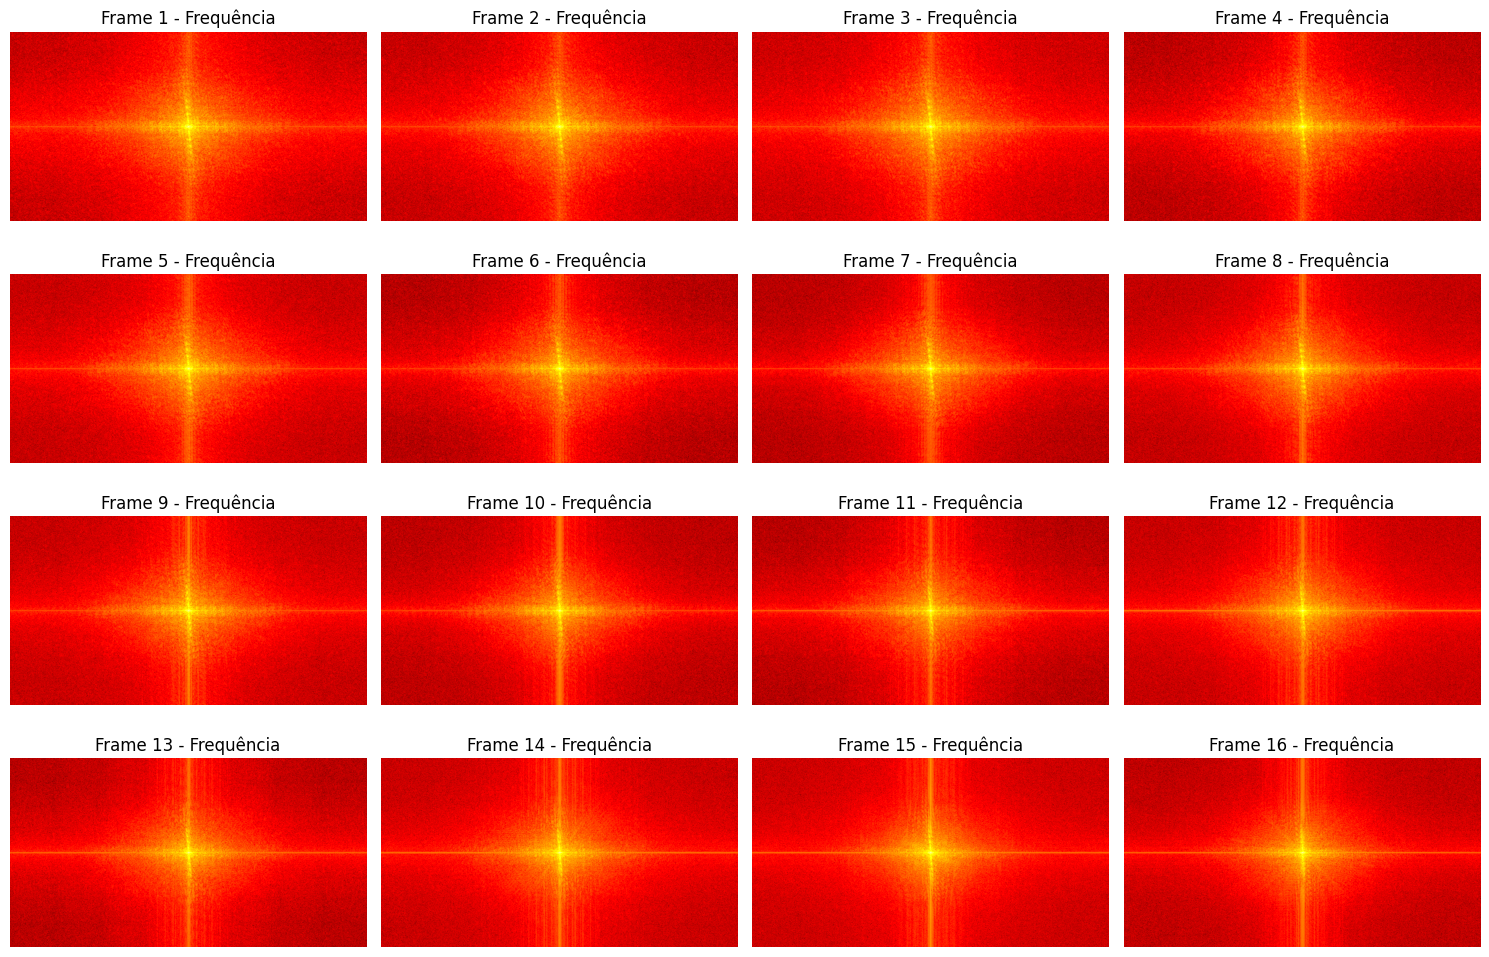

Predição: Deepfake com confiança 0.4315


In [88]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

def extract_frames_from_video(video_path, num_frames=16):
    cap = cv2.VideoCapture(video_path)
    frames = []
    
    if not cap.isOpened():
        print("Erro ao abrir o vídeo!")
        return None
    
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    step = max(frame_count // num_frames, 1)
    
    for i in range(num_frames):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i * step)
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    
    cap.release()
    return frames

def apply_fourier_transform(frame):
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    f = np.fft.fft2(gray_frame)
    fshift = np.fft.fftshift(f)  

    magnitude = np.abs(fshift)
    
    return magnitude

def visualize_frequency_analysis(frames, num_frames=16):
    plt.figure(figsize=(15, 10))
    
    for i, frame in enumerate(frames):
        magnitude = apply_fourier_transform(frame)
        
        plt.subplot(4, 4, i+1)
        plt.imshow(np.log(magnitude + 1), cmap='hot')  
        plt.title(f'Frame {i+1} - Frequência')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def predict_and_generate_frequency_analysis(video_path, model, extract_face_method='yolo', num_frames=16):
    frames = extract_frames_from_video(video_path, num_frames=num_frames)  
    
    if frames is None or len(frames) == 0:
        print(f"Erro: Nenhum frame extraído de {video_path}")
        return None, None
    
    frames_normalized = np.array(frames) / 255.0  
    frames_expanded = np.expand_dims(frames_normalized, axis=0)  
    prediction = model.predict(frames_expanded)
    prob_deepfake = prediction[0][0]
    
    threshold = 0.5
    pred_label = "Real" if prob_deepfake >= threshold else "Deepfake"

    # Visualizar a análise de frequência
    visualize_frequency_analysis(frames)

    return pred_label, prob_deepfake

# Testando com um vídeo
video_path = '/kaggle/input/celeb-fake/id0_id1_0000.mp4' 
pred_label, prob_deepfake = predict_and_generate_frequency_analysis(video_path, loaded_model)

print(f'Predição: {pred_label} com confiança {prob_deepfake:.4f}')


In [22]:
def evaluate_videos2(video_dir, extract_face):
    print(extract_face)
    initial_time = datetime.datetime.now()
    print(f"Start at {initial_time.strftime('%d-%m-%Y %H:%M:%S')}")
    
    true_labels = []
    pred_labels = []
    pred_probs = []  

    for class_label in  ["Real", "Deepfake"]:
        class_label_dir = "celebe-real" if class_label == "Real" else "celeb-fake"
        class_dir = os.path.join(video_dir, class_label_dir)
        print(class_dir)

        if not os.path.exists(class_dir):
            continue

        video_files = sorted([f for f in os.listdir(class_dir) if f.endswith(".mp4")])

        for video_file in video_files:
            video_path = os.path.join(class_dir, video_file)
            print(f"\nProcessando: {video_file} ({class_label})")

            # Extração de frames e detecção de deepfake
            label, confidence = predict_and_generate_frequency_analysis(video_path, loaded_model, extract_face)
            
            pred_label = label

            # Salvar rótulos reais e preditos
            true_labels.append(1 if class_label == "Real" else 0)  
            pred_labels.append(1 if pred_label == "Real" else 0)
            pred_probs.append(confidence)

    # Gerar matriz de confusão
    cm = confusion_matrix(true_labels, pred_labels)
    df_cm = pd.DataFrame(cm, index=["Real", "Deepfake"], columns=["Predito Real", "Predito Deepfake"])

    # Exibir matriz de confusão
    plt.figure(figsize=(6, 5))
    sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
    plt.xlabel("Predição")
    plt.ylabel("Real")
    plt.title("Matriz de Confusão - Detecção de Deepfake")
    plt.show()

    # Calcular métricas
    acc = accuracy_score(true_labels, pred_labels)
    f1 = f1_score(true_labels, pred_labels)
    auc = roc_auc_score(true_labels, pred_probs) if len(set(true_labels)) > 1 else None 
    
    # Exibir relatório de classificação
    print("\nRelatório de Classificação:")
    print(classification_report(true_labels, pred_labels, target_names=["Real", "Deepfake"]))
    print(f"Acurácia: {acc:.4f}")
    print(f"F1-score: {f1:.4f}")
    if auc is not None:
        print(f"AUC: {auc:.4f}")
    else:
        print("AUC: Não disponível (apenas uma classe presente nos dados)")

    final_time = datetime.datetime.now()
    duration = final_time - initial_time
    print(f"Finish at {final_time.strftime('%d-%m-%Y %H:%M:%S')}, duration: {duration}")
    
    return acc, f1, auc


yolo
Start at 19-03-2025 14:30:12
/kaggle/input/celebe-real

Processando: id0_0000.mp4 (Real)
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step

Processando: id0_0001.mp4 (Real)
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step

Processando: id0_0002.mp4 (Real)
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step

Processando: id0_0003.mp4 (Real)
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step

Processando: id0_0004.mp4 (Real)
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step

Processando: id0_0005.mp4 (Real)
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step

Processando: id0_0006.mp4 (Real)
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step

Processando: id0_0007.mp4 (Real)
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step

Processando: id0_0008.mp4 (Real)
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step

Processando: id0_0009.mp4 (Real)
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step

Processando: id1_0000.mp4 (Real)
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step

Processando: id1_0001.mp4 (Real)
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step

Processando: id1_0002.mp4 (Real)
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step

Processan

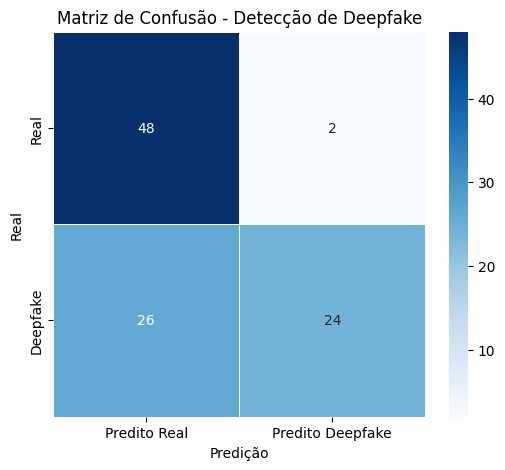


Relatório de Classificação:
              precision    recall  f1-score   support

        Real       0.65      0.96      0.77        50
    Deepfake       0.92      0.48      0.63        50

    accuracy                           0.72       100
   macro avg       0.79      0.72      0.70       100
weighted avg       0.79      0.72      0.70       100

Acurácia: 0.7200
F1-score: 0.6316
AUC: 0.6498
Finish at 19-03-2025 14:50:01, duration: 0:19:48.719812


(0.72, 0.631578947368421, 0.6498)

In [23]:
## Diretório de vídeos de teste YOLO
video_test_dir = "/kaggle/input/"

# Avaliação de todos os vídeos no diretório
evaluate_videos2(video_test_dir, 'yolo')

### Rascunho Sensitivity analysis

In [103]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

import numpy as np
import tensorflow as tf

def occlusion_sensitivity_analysis(model, frames, occlusion_size=20, step=20):
    frames = np.array(frames)
    if frames.shape[0] != 16:
        raise ValueError(f"O modelo espera 16 frames, mas recebeu {frames.shape[0]}.")

    frames = np.expand_dims(frames, axis=0) 

    original_prediction = model.predict(frames, verbose=0)[0][0]

    heatmap = np.zeros((224, 224))

    occlusion_masks = []
    positions = []

    for x in range(0, 224, step):
        for y in range(0, 224, step):
            occluded_frames = frames.copy()
            occluded_frames[:, :, x:x+occlusion_size, y:y+occlusion_size, :] = 0
            occlusion_masks.append(occluded_frames)
            positions.append((x, y))

    occlusion_masks = np.vstack(occlusion_masks)  # (N, 16, 224, 224, 3)
    predictions = model.predict(occlusion_masks, verbose=0)[:, 0]

    for i, (x, y) in enumerate(positions):
        heatmap[x:x+occlusion_size, y:y+occlusion_size] += original_prediction - predictions[i]

    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap




def visualize_occlusion_sensitivity(video_path, model, extract_face_method, num_frames=16):
    frames = extract_frames(video_path, process=extract_face_method, num_frames=num_frames)

    if len(frames) != 16:
        raise ValueError(f"Erro: Extração gerou {len(frames)} frames, mas o modelo precisa de 16.")

    heatmap = occlusion_sensitivity_analysis(model, frames)  

    frames = np.expand_dims(np.array(frames), axis=0)
    prediction = model.predict(frames)
    prob_deepfake = prediction[0][0]
    pred_label = "Deepfake" if prob_deepfake > 0.5 else "Real"

    return pred_label, prob_deepfake, heatmap



In [111]:
def show_heatmap(heatmap):
    # Exibir o heatmap
    plt.figure(figsize=(6, 6))
    plt.imshow(heatmap, cmap='jet', alpha=0.7)
    plt.colorbar()
    plt.title("Occlusion Sensitivity Analysis")
    plt.axis("off")
    plt.show()


def show_image_heatmap(video_path, heatmap):
    # Carregar o primeiro frame
    frames = extract_frames(video_path, process='yolo', num_frames=16)
    first_frame = cv2.cvtColor(frames[0], cv2.COLOR_RGB2BGR)  # Converte para BGR (formato OpenCV)
    
    # Redimensiona o heatmap para o tamanho da imagem
    heatmap_resized = cv2.resize(heatmap, (224, 224))
    
    # Converte o heatmap para formato de cor e normaliza
    heatmap_colored = cv2.applyColorMap((heatmap_resized * 255).astype(np.uint8), cv2.COLORMAP_JET)
    
    # Sobrepõe ao frame original (com alpha para transparência)
    overlay = cv2.addWeighted(first_frame, 0.6, heatmap_colored, 0.4, 0)
    
    # Exibir imagem final
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))  # Converte de volta para RGB
    plt.axis("off")
    plt.title("Occlusion Sensitivity Map sobreposto ao frame")
    plt.show()


0: 352x640 1 FACE, 110.4ms
Speed: 4.1ms preprocess, 110.4ms inference, 1.3ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 FACE, 103.7ms
Speed: 3.5ms preprocess, 103.7ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 FACE, 111.0ms
Speed: 3.5ms preprocess, 111.0ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 FACE, 107.9ms
Speed: 3.3ms preprocess, 107.9ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 FACE, 113.4ms
Speed: 3.7ms preprocess, 113.4ms inference, 1.3ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 FACE, 105.2ms
Speed: 3.6ms preprocess, 105.2ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 FACE, 104.5ms
Speed: 3.5ms preprocess, 104.5ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 FACE, 104.9ms
Speed: 3.6ms preprocess, 104.9ms inference, 1.2ms postprocess per image at shape (1, 3, 35

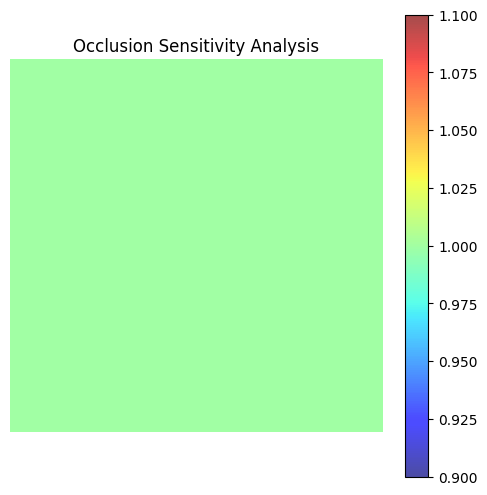


0: 352x640 1 FACE, 110.3ms
Speed: 3.2ms preprocess, 110.3ms inference, 1.3ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 FACE, 103.4ms
Speed: 3.3ms preprocess, 103.4ms inference, 1.1ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 FACE, 101.7ms
Speed: 3.4ms preprocess, 101.7ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 FACE, 102.9ms
Speed: 3.1ms preprocess, 102.9ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 FACE, 103.2ms
Speed: 3.5ms preprocess, 103.2ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 FACE, 104.4ms
Speed: 3.3ms preprocess, 104.4ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 FACE, 138.7ms
Speed: 3.6ms preprocess, 138.7ms inference, 1.3ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 FACE, 116.0ms
Speed: 4.0ms preprocess, 116.0ms inference, 1.6ms postprocess per image at shape (1, 3, 35

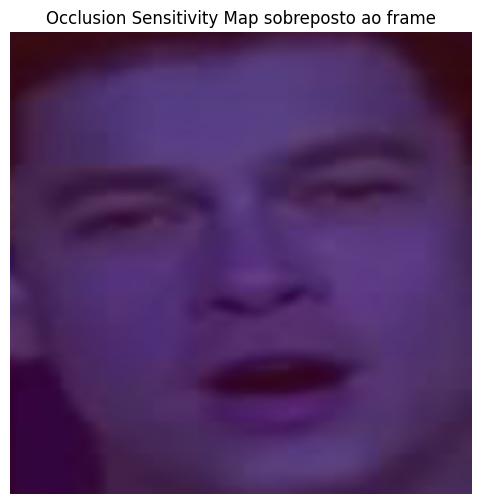

In [112]:
# Testando com um vídeo Fake
video_path = '/kaggle/input/celeb-fake/id0_id1_0000.mp4' 
# Chamada da função para obter predição e heatmap
pred_label, prob_deepfake, heatmap = visualize_occlusion_sensitivity(video_path, loaded_model, 'yolo')

# Exibir predição
print(f'Predição: {pred_label} com confiança {prob_deepfake:.4f}')

show_heatmap(heatmap)
show_image_heatmap(video_path, heatmap)


0: 352x640 1 FACE, 104.2ms
Speed: 4.0ms preprocess, 104.2ms inference, 1.1ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 FACE, 104.1ms
Speed: 3.2ms preprocess, 104.1ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 FACE, 104.5ms
Speed: 3.5ms preprocess, 104.5ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 FACE, 105.8ms
Speed: 3.7ms preprocess, 105.8ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 FACE, 106.1ms
Speed: 3.5ms preprocess, 106.1ms inference, 2.1ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 FACE, 105.2ms
Speed: 3.8ms preprocess, 105.2ms inference, 1.3ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 FACE, 116.5ms
Speed: 3.9ms preprocess, 116.5ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 FACE, 109.9ms
Speed: 3.5ms preprocess, 109.9ms inference, 1.2ms postprocess per image at shape (1, 3, 35

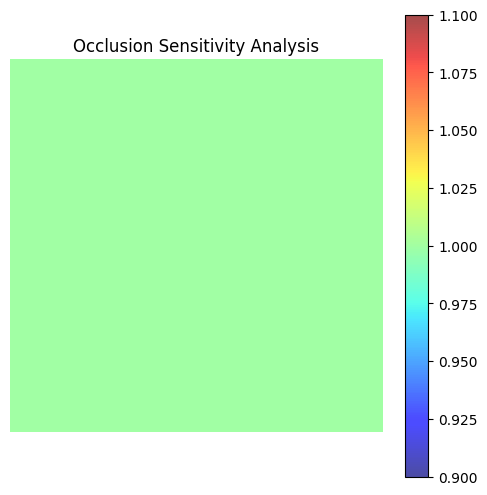


0: 352x640 1 FACE, 111.8ms
Speed: 2.9ms preprocess, 111.8ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 FACE, 110.4ms
Speed: 3.3ms preprocess, 110.4ms inference, 1.8ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 FACE, 111.1ms
Speed: 3.5ms preprocess, 111.1ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 FACE, 118.7ms
Speed: 3.1ms preprocess, 118.7ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 FACE, 117.4ms
Speed: 3.1ms preprocess, 117.4ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 FACE, 122.1ms
Speed: 3.0ms preprocess, 122.1ms inference, 1.3ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 FACE, 117.1ms
Speed: 2.9ms preprocess, 117.1ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 FACE, 117.6ms
Speed: 3.1ms preprocess, 117.6ms inference, 1.7ms postprocess per image at shape (1, 3, 35

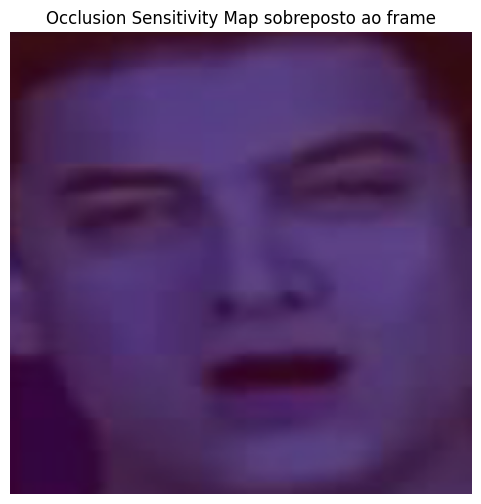

In [113]:
# Testando com um vídeo Real
video_path = '/kaggle/input/celebe-real/id0_0000.mp4' 
# Chamada da função para obter predição e heatmap
pred_label, prob_deepfake, heatmap = visualize_occlusion_sensitivity(video_path, loaded_model, 'yolo')

# Exibir predição
print(f'Predição: {pred_label} com confiança {prob_deepfake:.4f}')

show_heatmap(heatmap)
show_image_heatmap(video_path, heatmap)